In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets,models,transforms

import json
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt


In [44]:
normalize = transforms.Normalize(
    mean =[0.485,0.456,0.406],
    std = [0.229,0.224,0.225])

preprocess = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])
resize256 = transforms.Compose([
     transforms.CenterCrop(256)
])

In [45]:
def occluding(Img,i,j):
    oc_h,oc_w=64,64
    rImg=resize256(Img)
    img_np = np.asarray(rImg)
    img_np.flags.writeable = True
    h_top = i
    h_under = i+oc_h 
    w_left = j
    w_light = j+oc_w
    if(h_top < 0):
     h_top = 0 
    if(h_under > 256):
     h_under = 256
    if(w_left < 0):
     w_left = 0
    if(w_light > 256):
     w_light = 256
    #occluding
    img_np[h_top:h_under,w_left:w_light,:]=0
    return Image.fromarray(np.uint8(img_np))

In [46]:
def classid(Img,labels):
    img_tensor = preprocess(Img)
    img_tensor.unsqueeze_(0)
    out = vgg16(img_tensor)
    out = nn.functional.softmax(out,dim=1)
    out = out.data.numpy() 
    max_id = np.argmax(out)    
    label = labels[max_id][1]
    print(max_id,label)
    return max_id

In [47]:
def predict(Img,labels,id):
    img_tensor = preprocess(Img)
    img_tensor.unsqueeze_(0)
    out = vgg16(img_tensor)
    out = nn.functional.softmax(out,dim=1)
    out = out.data.numpy() 
    maxprob = out[:,id]
    label = labels[id] 
    return Img ,label, maxprob

In [48]:
def mheatmap(image):
    c = 0
    size = 39*39
    hm_w,hm_h = 256,256 #PIL.size > (width,height)
    class_index = json.load(open('imagenet_class_index.json', 'r'))
    labels = {int (key):value for (key,value) in class_index.items()}
    heatmap_li = []
    labelid = classid(image,labels)
    for i in range(-56,hm_h,8):
     for j in range(-56,hm_w,8):
      c += 1
      oc_img=occluding(image,i,j)
      oc_img,oc_label,oc_prob = predict(oc_img,labels,labelid)
      heatmap_li.append(oc_prob)
     print('%d / %d'%(c,size))
    
    heatmap_np = np.array(heatmap_li)
    maps = np.reshape(heatmap_np,(39,39))
    np.save('./maps.npy',maps)

In [49]:
def hm_img_show(image,maps):
     
     preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
        ])

     fig=plt.figure()
     ax1 = fig.add_subplot(1,2,1)
     #cm = plt.get_cmap('YlOrRd')
     ax1 = sns.heatmap(maps,cmap = 'YlOrRd')

     Img = occluding(image,64,64)
     Img = preprocess(Img)
     Img = np.array(Img)
     ax2 = fig.add_subplot(1,2,2)
     ax2.grid(color='none')
     ax2.imshow(Img)

     plt.show()

In [50]:
if __name__ == '__main__':
 image = Image.open('/export/space/okamoto-ka/imgdata2/001.jpg')  
 vgg16 = models.vgg16(pretrained = True)
 vgg16.eval()  
 mheatmap(image)

146 albatross
39 / 1521
78 / 1521
117 / 1521
156 / 1521
195 / 1521
234 / 1521
273 / 1521
312 / 1521
351 / 1521
390 / 1521
429 / 1521
468 / 1521
507 / 1521
546 / 1521
585 / 1521
624 / 1521
663 / 1521
702 / 1521
741 / 1521
780 / 1521
819 / 1521
858 / 1521
897 / 1521
936 / 1521
975 / 1521
1014 / 1521
1053 / 1521
1092 / 1521
1131 / 1521
1170 / 1521
1209 / 1521
1248 / 1521
1287 / 1521
1326 / 1521
1365 / 1521
1404 / 1521
1443 / 1521
1482 / 1521
1521 / 1521


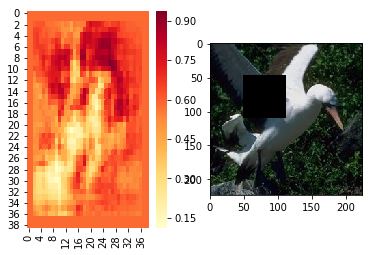

In [51]:
 maps = np.load('maps.npy')
 hm_img_show(image,maps)